# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация
Дата выдачи: 05.02.2021

Мягкий дедлайн: 01:59MSK 21.02.2021

Жесткий дедлайн: 01:59MSK 24.02.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.


Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [77]:
import keras
from keras.datasets import fashion_mnist
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import random
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifierCV

По традиции будем считать, что мы люди сильные и психику портить тоже не хотим, так что справимся без ворнингов))))

In [71]:
import warnings
warnings.filterwarnings("ignore")

In [72]:
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [5]:
class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.PCA = PCA(n_components=self.new_dim)

        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        else:
            self.model = SVC(kernel=self.classifier)

    def est_sigma2(self, X):
        batch_size = 1000000
        i = np.random.choice(X.shape[0], batch_size)
        j = np.random.choice(X.shape[0] - 1, batch_size)
        j[j >= i] += 1
        ij = np.stack([i, j], axis=1)
        sigma2 = np.median(np.sum(np.square(X[ij][:, 0] - X[ij][:, 1]), axis=1))

        return sigma2

    def fit(self, X, y):
        if self.use_PCA:
            pca_X = self.PCA.fit_transform(X)
        else:
            pca_X = X
            self.new_dim = X.shape[1]

        sigma2 = self.est_sigma2(pca_X)

        self.W = np.random.normal(0, 1 / np.sqrt(sigma2), (self.new_dim, self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, self.n_features)

        new_X = np.cos(pca_X @ self.W + self.b)
        
        self.model.fit(new_X, y)

        return self

    def predict_proba(self, X):
        if self.use_PCA:
            pca_X = self.PCA.transform(X)
        else:
            pca_X = X
            self.new_dim = X.shape[1]

        new_X = np.cos(pca_X @ self.W + self.b)
        res = self.model.predict_proba(new_X)

        return res 
        
    def predict(self, X):
        if self.use_PCA:
            pca_X = self.PCA.transform(X)
        else:
            pca_X = X
            self.new_dim = X.shape[1]

        new_X = np.cos(pca_X @ self.W + self.b)
        res = self.model.predict(new_X)

        return res

In [11]:
%%time

pip = RFFPipeline()
pip.fit(x_train, y_train)
y_pred = pip.predict(x_test)

print("Доля верных ответов на тесте: ", accuracy_score(y_pred, y_test) * 100, "%", sep='')

Доля верных ответов на тесте: 85.94000000000001%
CPU times: user 1min 23s, sys: 19.1 s, total: 1min 42s
Wall time: 53.7 s


Ну, вроде можно жить дальше

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [6]:
x_train.shape

(60000, 784)

In [7]:
x_test.shape

(10000, 784)

Рассмотрим случайное подмножество объектов из обучающей выборке, а то иначе SVM будет работать вечность( Я взяла размер равный 1/6 от всех объектов обучающей выборки и также уменьшила размер тестовой выборки, чтобы она была соизмерима обучающей).

Извиняюсь, что так сильно уменьшила, это произошло после того, как SVM на 20000 учился больше 2 часов и я психанула...

In [15]:
idxs = random.sample(range(x_train.shape[0]), 10000)
n_x_train = x_train[idxs]
n_y_train = y_train[idxs]

idxs_2 = random.sample(range(x_test.shape[0]), 2000)
n_x_test = x_test[idxs_2]
n_y_test = y_test[idxs_2]

In [15]:
%%time

pip = RFFPipeline(classifier='linear')
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов на тесте для SVM с линейным ядром (RFF): ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов на тесте для SVM с линейным ядром (RFF): 86.1%
CPU times: user 39.7 s, sys: 1.42 s, total: 41.1 s
Wall time: 39.5 s


In [16]:
%%time

model = SVC(kernel='linear')
model.fit(n_x_train, n_y_train)
y_pred = model.predict(n_x_test)

print("Доля верных ответов на тесте для SVM с линейным ядром (SVM): ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов на тесте для SVM с линейным ядром (SVM): 79.10000000000001%
CPU times: user 40.3 s, sys: 4.31 ms, total: 40.3 s
Wall time: 40.3 s


Как мы видим просто SVM справляется хуже, причем в случае линейного ядра я бы сказала, что значительно хуже. 

In [17]:
%%time

pip = RFFPipeline(classifier='poly')
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов на тесте для SVM с полиномиальным ядром (RFF): ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов на тесте для SVM с полиномиальным ядром (RFF): 85.1%
CPU times: user 50.9 s, sys: 1.4 s, total: 52.3 s
Wall time: 50.7 s


In [18]:
%%time

model = SVC(kernel='poly')
model.fit(n_x_train, n_y_train)
y_pred = model.predict(n_x_test)

print("Доля верных ответов на тесте для SVM с полиномиальным ядром (SVM): ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов на тесте для SVM с полиномиальным ядром (SVM): 83.55%
CPU times: user 42.6 s, sys: 7.45 ms, total: 42.7 s
Wall time: 42.7 s


И в случае полиномиального ядра SVM на всех признаках также справляется хуже.

In [19]:
%%time

pip = RFFPipeline(classifier='rbf')
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов на тесте для SVM с Гауссовым ядром (RFF): ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов на тесте для SVM с Гауссовым ядром (RFF): 84.8%
CPU times: user 55.1 s, sys: 1.41 s, total: 56.5 s
Wall time: 54.8 s


In [20]:
%%time

model = SVC(kernel='rbf')
model.fit(n_x_train, n_y_train)
y_pred = model.predict(n_x_test)

print("Доля верных ответов на тесте для SVM с Гауссовым ядром (SVM): ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов на тесте для SVM с Гауссовым ядром (SVM): 86.3%
CPU times: user 42.9 s, sys: 8.92 ms, total: 42.9 s
Wall time: 42.9 s


А тут вот лучше... Ну, не будем особо обращать на это внимание и скажем, почему подход с генерацией новых признаков с PCA работает лучше. Как было сказано (или будет сказано далее, мне лень искать) PCA помогает убрать мусорные признаки, таким образом наш метод генерирует новые признаки из +- нормальных, а значит и они тоже получаются нормальными. И таким образом новый набор признаков может быть лучше, чем исходный и модель на нем будет давать лучшее качество. Вот и все :) 

Говоря о времени обучения, явным аутсайдером является SVM на исходных признаках. На выведенных примерах это не заметно, но при увеличении числа объектов выборки его время работы ооооочень сильно увеличивается. Я так и не дождалась, когда у меня обучится SVM на 20000 объектах. А ждала я, на минуточку, больше 2-ух часов... В общем, было грустно. 

Теперь хотим использовать XGBoost И для начала подберем для него параметры - n_estimators и learning_rate. Поиск идет две тысячи лет, так что оставим и там и там по 3 вариации параметров, чтобы примерно понимать, что нам нужно. 

In [25]:
params = {
    'n_estimators' : np.linspace(10, 50, 3, dtype=int),
    'learning_rate' : np.linspace(0.1, 0.7, 3),
}

searcher = RandomizedSearchCV(xgb.XGBClassifier(), params, scoring='accuracy')
searcher.fit(n_x_train, n_y_train)

best_params = searcher.best_params_
best_params

{'learning_rate': 0.4, 'n_estimators': 50}

Да, да, я вижу, что n_estimators вышло равное максимальному порогу... Но на больших n_estimators оно считалось больше 2 часов и моего терпения не хватало(

Теперь обучим XGBoost. Возьмем размерность 50, как было по умолчанию в нашем классе.

In [23]:
%%time

pca = PCA(n_components=50)
tr_x_train = pca.fit_transform(n_x_train)
tr_x_test = pca.transform(n_x_test)

model = xgb.XGBClassifier(n_estimators=best_params['n_estimators'], 
                          learning_rate=best_params['learning_rate'])

model.fit(tr_x_train, n_y_train)
y_pred = model.predict(tr_x_test)

print("Доля верных ответов на тесте для XGBoost: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')


Доля верных ответов на тесте для XGBoost: 84.35000000000001%
CPU times: user 18.4 s, sys: 1.32 s, total: 19.7 s
Wall time: 18.3 s


Попробуем еще увеличить n_estimators, так как наш поиск выше выдал крайнее значение, а значит реально оптимальное выше (но с большими числами RandomizedSearchCV работал больше двух часов, так что не судьба).

In [24]:
%%time

model = xgb.XGBClassifier(n_estimators=500, 
                          learning_rate=best_params['learning_rate'])

model.fit(tr_x_train, n_y_train)
y_pred = model.predict(tr_x_test)

print("Доля верных ответов на тесте для XGBoost: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')


Доля верных ответов на тесте для XGBoost: 85.7%
CPU times: user 2min 11s, sys: 92.5 ms, total: 2min 11s
Wall time: 2min 11s


Ну, становится получше, конечно. Но есть ощущение, что до 86.3 (наилучшего результата среди других методов, использующих генерацию новх признаков) все равно не дойдет. Так что скажем, что XGBoost справился с задачей хуже. 

Ну и так же XGBoost с достаточно большим n_estimators учился дольше всех, а еще и параметры подбираются просто вечность, так что тут минус по всем фронтам, конечно (прости, XGBoost, ничего личного).

И таким образом, мы пришли к тому, что из исследуемых нами в этом пункте методов, и по критерию качества, и по критерию скорости обучения и применения побеждает подход со случайными признаками. 

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

1) Так как не указано, на чем именно это выяснять, то возьму логистическую регрессию и SVM с линейным ядром и протестирую на них. На это раз будем снова использовать все объекты из выборки.

In [25]:
%%time

pip = RFFPipeline(classifier='logreg')
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов на тесте для logreg с PCA: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов на тесте для logreg с PCA: 85.85000000000001%
CPU times: user 15.2 s, sys: 10.3 s, total: 25.5 s
Wall time: 13.4 s


In [26]:
%%time

p = RFFPipeline(classifier='logreg', use_PCA=False)
p.fit(x_train, y_train)
y_pred = p.predict(x_test)

print("Доля верных ответов на тесте для logreg без PCA: ", accuracy_score(y_pred, y_test) * 100, "%", sep='')

Доля верных ответов на тесте для logreg без PCA: 10.9%
CPU times: user 16.2 s, sys: 1.94 s, total: 18.2 s
Wall time: 11.5 s


In [27]:
%%time

pip = RFFPipeline(classifier='linear')
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов на тесте для SVM с PCA: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов на тесте для SVM с PCA: 85.75%
CPU times: user 39.3 s, sys: 1.45 s, total: 40.8 s
Wall time: 39.1 s


In [24]:
%%time

pip = RFFPipeline(classifier='linear', use_PCA=False)
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов на тесте для SVM без PCA: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов на тесте для SVM без PCA: 10.549999999999999%
CPU times: user 28min 22s, sys: 440 ms, total: 28min 22s
Wall time: 28min 27s


Помогает ли предварительное понижение размерности? Ну как вам сказать. Тут проблема в том, что если никак не масштабировать данные, то выходит то, что выше. То есть без PCA качество ну совсем близко к нулю. 

А теперь попробуем сделать тоже самое, но отмасштабируем наши данные, чтобы с исходными признаками можно было нормально работать и генерировать из них новые.

Простите, тут будет новая подвыборка, потому что я не готова перезапускать весь код выше.

Еще тут возникла проблема с тем, что при нормализации и веторных вычислениях сигмы у коллаба кончается ОЗУ... Так что я просто тестила с циклом в функции, вычисляющей сигму. Решила в итоге оставить векторную версию, она выглядит пооптимальнее для всего остального, но с циклом функция выглядела так:

In [1]:
"""
def est_sigma2(self, X):
        batch_size = 1000000
        res = []
        for i in range(batch_size):
            ind_1, ind_2 = np.random.randint(0, X.shape[0], size=2)
            res.append(np.linalg.norm(X[ind_1] - X[ind_2])**2)

        sigma2 = np.median(res)

        return sigma2
"""

In [20]:
idxs = random.sample(range(x_train.shape[0]), 10000)
n_x_train = x_train[idxs]
n_y_train = y_train[idxs]

idxs_2 = random.sample(range(x_test.shape[0]), 2000)
n_x_test = x_test[idxs_2]
n_y_test = y_test[idxs_2]

In [21]:
normalized_x_train = n_x_train / 255
normalized_x_test = n_x_test / 255

In [22]:
%%time

pip = RFFPipeline(classifier='logreg')
pip.fit(normalized_x_train, n_y_train)
y_pred = pip.predict(normalized_x_test)

print("Доля верных ответов на тесте для logreg с PCA с нормализацией: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов на тесте для logreg с PCA с нормализацией: 85.9%
CPU times: user 37.5 s, sys: 10.2 s, total: 47.8 s
Wall time: 36 s


In [23]:
%%time

pip = RFFPipeline(classifier='logreg', use_PCA=False)
pip.fit(normalized_x_train, n_y_train)
y_pred = pip.predict(normalized_x_test)

print("Доля верных ответов на тесте для logreg без PCA с нормализацией: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов на тесте для logreg без PCA с нормализацией: 84.45%
CPU times: user 44.1 s, sys: 9.25 s, total: 53.4 s
Wall time: 42.1 s


In [24]:
%%time

pip = RFFPipeline(classifier='linear')
pip.fit(normalized_x_train, n_y_train)
y_pred = pip.predict(normalized_x_test)

print("Доля верных ответов на тесте для SVM с PCA с нормализацией: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов на тесте для SVM с PCA с нормализацией: 85.5%
CPU times: user 1min 7s, sys: 1.47 s, total: 1min 9s
Wall time: 1min 7s


In [25]:
%%time

pip = RFFPipeline(classifier='linear', use_PCA=False)
pip.fit(normalized_x_train, n_y_train)
y_pred = pip.predict(normalized_x_test)

print("Доля верных ответов на тесте для SVM без PCA с нормализацией: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов на тесте для SVM без PCA с нормализацией: 83.2%
CPU times: user 1min 15s, sys: 308 ms, total: 1min 15s
Wall time: 1min 15s


Как мы видим, при использовании нормализации качество работы моделей с PCA и без PCA примерно сравнимо. И вот тут уже можно сделать вывод о том, что итоговое качество с использованием PCA немного выше, чем без использования. Так что сделаем вывод, что PCA помогает, да. Вообще по сути PCA помогает нам отобрать из всех исходных признаков нормальные. И получается, что в случае с PCA мы генерируем дальше признаки не из всех, что были, а только из +- сносных, когда в случае, если мы не используем PCA новые признаки могут генерироваться в том числе из каких-то совсем мусорных, что, конечно, скажется на качестве (хоть и не очень сильно).

2) Ну что сказать, с SVM-ом мне хочется плакать. А мы, как уже сказано в начале работы, бережем свое психическое здоровье... Так что рассматривать буду логистическую регрессию в данном пункте.



In [27]:
acc_list = []
n_fs = np.linspace(10, 2000, 40, dtype=int)

for n in n_fs:
    pip = RFFPipeline(classifier='logreg', n_features=n)
    pip.fit(n_x_train, n_y_train)
    y_pred = pip.predict(n_x_test)
    cur_acc = accuracy_score(y_pred, n_y_test) * 100
    acc_list.append(cur_acc)

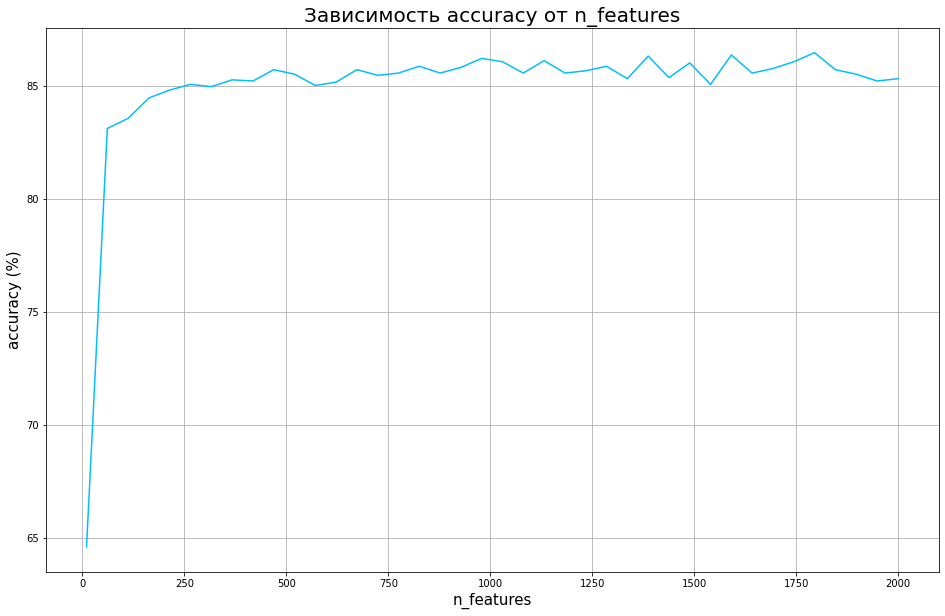

In [28]:
plt.figure(figsize=(16, 10))
plt.plot(n_fs, acc_list, color='deepskyblue')
plt.xlabel('n_features', size=15)
plt.ylabel('accuracy (%)', size=15)
plt.title('Зависимость accuracy от n_features', size=20)
plt.grid()
plt.show()

Как можно заметить по графику, итоговое качество растет при росте количества признаков только до определенного момента, а затем уже начинает расти очень медленно/почти не изменяться. Что в целом логично, так как при небольшом количестве признаков (в нашем случае, видимо, меньше 500) их количества может быть недостаточно, чтобы выборка получилась линейно разделимой, чего мы и хотим добиться, используя ядровые методы. А если количество признаков уже достаточно большое, то качество работы растет медленно, так выборка уже является практически линейно разделимой (близкой к этому).

Насчет плато. По графику видно, что где-то начиная с 800 признаков и до 2000 accuracy немного колебалась, при этом оставаясь примерно на уровне 85%. Если это можно назвать платом, то давайте назовем... Кажется, что качество уже все-таки не растет, а просто колеблется между какими-то значениями. 

3) Важно ли какую модель обучать? Так, ну разные модели я уже обучала выше, не буду делать тут это снова, просто напишу вывод. Скопируем сюда все наши результаты, потому что я не готова обучать все заново и составлять красивую таблику...

Доля верных ответов на тесте для logreg с PCA: 85.85000000000001%

Доля верных ответов на тесте для linear SVM с PCA: 85.75%

Доля верных ответов на тесте для SVM с полиномиальным ядром с PCA: 85.1%

Доля верных ответов на тесте для SVM с Гауссовым ядром с PCA: 84.8%

Доля верных ответов на тесте для logreg без PCA с нормализацией: 84.45%

Доля верных ответов на тесте для linear SVM без PCA с нормализацией: 83.2%


Как можно заметить, и с PCA, и без PCA лучшее качество дала логистическая регрессия. Не сказать, что разница прям коллосальная, но она есть. Из чего можно сделать вывод, что выбор модели все-таки влияет на обучение (что логично, так что я не знаю, что именно от меня хотели услышать в ответе на этот вопрос...)




### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

Надеюсь, я правильно все поняла (ай эм сори, ай донт спик инглиш вери гуд, бат ай спик инглиш фифти-фифти) и все, что нам нужно реализовать - это вычисление матрицы W по описанной в статье схеме.

<img src="https://sun9-36.userapi.com/impf/Bc2Sswyw1j-N62u8ygo7dLHhV6W58L2ft662nw/_52hftRmOJY.jpg?size=1243x357&quality=96&proxy=1&sign=026e2092d206bc01ae20cbe0343d0796&type=album">

In [16]:
class ORFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.PCA = PCA(n_components=self.new_dim)

        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        else:
            self.model = SVC(kernel=self.classifier)

    def est_sigma2(self, X):
        batch_size = 1000000
        i = np.random.choice(X.shape[0], batch_size)
        j = np.random.choice(X.shape[0] - 1, batch_size)
        j[j >= i] += 1
        ij = np.stack([i, j], axis=1)
        sigma2 = np.median(np.sum(np.square(X[ij][:, 0] - X[ij][:, 1]), axis=1))

        return sigma2

    def fit(self, X, y):
        if self.use_PCA:
            pca_X = self.PCA.fit_transform(X)
        else:
            pca_X = X
            self.new_dim = X.shape[1]

        sigma2 = self.est_sigma2(pca_X)

        H = np.random.rand(self.n_features, self.new_dim)
        u, s, vh = np.linalg.svd(H, full_matrices=False)
        S = u @ vh
        Q = np.diag(np.random.chisquare(self.new_dim, self.new_dim))

        self.W = 1 / np.sqrt(sigma2) * np.dot(S, Q)
        self.b = np.random.uniform(-np.pi, np.pi, self.n_features)

        new_X = np.cos(pca_X @ self.W.T + self.b)
        
        self.model.fit(new_X, y)

        return self

    def predict_proba(self, X):
        if self.use_PCA:
            pca_X = self.PCA.transform(X)
        else:
            pca_X = X
            self.new_dim = X.shape[1]

        new_X = np.cos(pca_X @ self.W.T + self.b)
        res = self.model.predict_proba(new_X)

        return res 
        
    def predict(self, X):
        if self.use_PCA:
            pca_X = self.PCA.transform(X)
        else:
            pca_X = X
            self.new_dim = X.shape[1]

        new_X = np.cos(pca_X @ self.W.T + self.b)
        res = self.model.predict(new_X)

        return res

In [7]:
idxs = random.sample(range(x_train.shape[0]), 10000)
n_x_train = x_train[idxs]
n_y_train = y_train[idxs]

idxs_2 = random.sample(range(x_test.shape[0]), 2000)
n_x_test = x_test[idxs_2]
n_y_test = y_test[idxs_2]

In [8]:
%%time

pip = RFFPipeline(classifier='logreg')
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов RFF на тесте для logreg с PCA: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов RFF на тесте для logreg с PCA: 84.89999999999999%
CPU times: user 20.8 s, sys: 13.4 s, total: 34.2 s
Wall time: 18.2 s


In [19]:
%%time

pip = ORFPipeline(classifier='logreg')
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов ORF на тесте для logreg с PCA: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов ORF на тесте для logreg с PCA: 85.7%
CPU times: user 20.5 s, sys: 12.8 s, total: 33.3 s
Wall time: 17.4 s


In [20]:
%%time

pip = RFFPipeline(classifier='linear')
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов RFF на тесте для linear SVM с PCA: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов RFF на тесте для linear SVM с PCA: 85.39999999999999%
CPU times: user 45.9 s, sys: 1.63 s, total: 47.6 s
Wall time: 45.7 s


In [21]:
%%time

pip = ORFPipeline(classifier='linear')
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов ORF на тесте для linear SVM с PCA: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов ORF на тесте для linear SVM с PCA: 84.7%
CPU times: user 47.1 s, sys: 1.67 s, total: 48.8 s
Wall time: 47 s


In [12]:
%%time

pip = RFFPipeline(classifier='poly')
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов RFF на тесте для poly SVM с PCA: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов RFF на тесте для poly SVM с PCA: 85.1%
CPU times: user 57.8 s, sys: 1.75 s, total: 59.5 s
Wall time: 57.7 s


In [13]:
%%time

pip = ORFPipeline(classifier='poly')
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов ORF на тесте для poly SVM с PCA: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов ORF на тесте для poly SVM с PCA: 85.9%
CPU times: user 1min 11s, sys: 1.69 s, total: 1min 13s
Wall time: 1min 11s


In [14]:
%%time

pip = RFFPipeline(classifier='rbf')
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов RFF на тесте для rbf SVM с PCA: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов RFF на тесте для rbf SVM с PCA: 84.3%
CPU times: user 1min 2s, sys: 1.63 s, total: 1min 3s
Wall time: 1min 1s


In [15]:
%%time

pip = ORFPipeline(classifier='rbf')
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов ORF на тесте для rbf SVM с PCA: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов ORF на тесте для rbf SVM с PCA: 85.75%
CPU times: user 1min 5s, sys: 1.64 s, total: 1min 6s
Wall time: 1min 5s


(С use_PCA тестить не будем, потому что при нормализации у меня вылетает ОЗУ в коллабе при векторных вычислениях, а обратно цикл писать не хочется)

Ну что ж, как мы видим, в трех из четырех случаев, ORF дал немного более высокое качество, чем RFF. По времени же оба алгоритма работали примерно одинаково. Такие вот дела.

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [6]:
class Pipeline_sign(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.PCA = PCA(n_components=self.new_dim)

        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        else:
            self.model = SVC(kernel=self.classifier)

    def est_sigma2(self, X):
        batch_size = 1000000
        i = np.random.choice(X.shape[0], batch_size)
        j = np.random.choice(X.shape[0] - 1, batch_size)
        j[j >= i] += 1
        ij = np.stack([i, j], axis=1)
        sigma2 = np.median(np.sum(np.square(X[ij][:, 0] - X[ij][:, 1]), axis=1))

        return sigma2

    def fit(self, X, y):
        if self.use_PCA:
            pca_X = self.PCA.fit_transform(X)
        else:
            pca_X = X
            self.new_dim = X.shape[1]

        sigma2 = self.est_sigma2(pca_X)

        self.W = np.random.normal(0, 1 / np.sqrt(sigma2), (self.new_dim, self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, self.n_features)

        new_X = np.sign(pca_X @ self.W + self.b)
        
        self.model.fit(new_X, y)

        return self

    def predict_proba(self, X):
        if self.use_PCA:
            pca_X = self.PCA.transform(X)
        else:
            pca_X = X
            self.new_dim = X.shape[1]

        new_X = np.sign(pca_X @ self.W + self.b)
        res = self.model.predict_proba(new_X)

        return res 
        
    def predict(self, X):
        if self.use_PCA:
            pca_X = self.PCA.transform(X)
        else:
            pca_X = X
            self.new_dim = X.shape[1]

        new_X = np.sign(pca_X @ self.W + self.b)
        res = self.model.predict(new_X)

        return res

In [50]:
class Pipeline_sin(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.PCA = PCA(n_components=self.new_dim)

        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        else:
            self.model = SVC(kernel=self.classifier)

    def est_sigma2(self, X):
        batch_size = 1000000
        i = np.random.choice(X.shape[0], batch_size)
        j = np.random.choice(X.shape[0] - 1, batch_size)
        j[j >= i] += 1
        ij = np.stack([i, j], axis=1)
        sigma2 = np.median(np.sum(np.square(X[ij][:, 0] - X[ij][:, 1]), axis=1))

        return sigma2

    def fit(self, X, y):
        if self.use_PCA:
            pca_X = self.PCA.fit_transform(X)
        else:
            pca_X = X
            self.new_dim = X.shape[1]

        sigma2 = self.est_sigma2(pca_X)

        self.W = np.random.normal(0, 1 / np.sqrt(sigma2), (self.new_dim, self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, self.n_features)

        new_X = np.sin(pca_X @ self.W + self.b)
        
        self.model.fit(new_X, y)

        return self

    def predict_proba(self, X):
        if self.use_PCA:
            pca_X = self.PCA.transform(X)
        else:
            pca_X = X
            self.new_dim = X.shape[1]

        new_X = np.sin(pca_X @ self.W + self.b)
        res = self.model.predict_proba(new_X)

        return res 
        
    def predict(self, X):
        if self.use_PCA:
            pca_X = self.PCA.transform(X)
        else:
            pca_X = X
            self.new_dim = X.shape[1]

        new_X = np.sin(pca_X @ self.W + self.b)
        res = self.model.predict(new_X)

        return res

In [57]:
class Pipeline_exp(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.PCA = PCA(n_components=self.new_dim)

        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        else:
            self.model = SVC(kernel=self.classifier)

    def est_sigma2(self, X):
        batch_size = 1000000
        i = np.random.choice(X.shape[0], batch_size)
        j = np.random.choice(X.shape[0] - 1, batch_size)
        j[j >= i] += 1
        ij = np.stack([i, j], axis=1)
        sigma2 = np.median(np.sum(np.square(X[ij][:, 0] - X[ij][:, 1]), axis=1))

        return sigma2

    def fit(self, X, y):
        if self.use_PCA:
            pca_X = self.PCA.fit_transform(X)
        else:
            pca_X = X
            self.new_dim = X.shape[1]

        sigma2 = self.est_sigma2(pca_X)

        self.W = np.random.normal(0, 1 / np.sqrt(sigma2), (self.new_dim, self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, self.n_features)

        new_X = np.exp(pca_X @ self.W + self.b)
        
        self.model.fit(new_X, y)

        return self

    def predict_proba(self, X):
        if self.use_PCA:
            pca_X = self.PCA.transform(X)
        else:
            pca_X = X
            self.new_dim = X.shape[1]

        new_X = np.exp(pca_X @ self.W + self.b)
        res = self.model.predict_proba(new_X)

        return res 
        
    def predict(self, X):
        if self.use_PCA:
            pca_X = self.PCA.transform(X)
        else:
            pca_X = X
            self.new_dim = X.shape[1]

        new_X = np.exp(pca_X @ self.W + self.b)
        res = self.model.predict(new_X)

        return res

In [106]:
class Pipeline_log(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.PCA = PCA(n_components=self.new_dim)

        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        else:
            self.model = SVC(kernel=self.classifier)

    def est_sigma2(self, X):
        batch_size = 1000000
        i = np.random.choice(X.shape[0], batch_size)
        j = np.random.choice(X.shape[0] - 1, batch_size)
        j[j >= i] += 1
        ij = np.stack([i, j], axis=1)
        sigma2 = np.median(np.sum(np.square(X[ij][:, 0] - X[ij][:, 1]), axis=1))

        return sigma2

    def fit(self, X, y):
        if self.use_PCA:
            pca_X = self.PCA.fit_transform(X)
        else:
            pca_X = X
            self.new_dim = X.shape[1]

        sigma2 = self.est_sigma2(pca_X)

        self.W = np.random.normal(0, 1 / np.sqrt(sigma2), (self.new_dim, self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, self.n_features)
        new_X = np.log1p((pca_X @ self.W + self.b) + np.max(pca_X @ self.W + self.b))
        
        self.model.fit(new_X, y)

        return self

    def predict_proba(self, X):
        if self.use_PCA:
            pca_X = self.PCA.transform(X)
        else:
            pca_X = X
            self.new_dim = X.shape[1]

        new_X = np.log1p((pca_X @ self.W + self.b) + np.max(pca_X @ self.W + self.b))
        res = self.model.predict_proba(new_X)

        return res 
        
    def predict(self, X):
        if self.use_PCA:
            pca_X = self.PCA.transform(X)
        else:
            pca_X = X
            self.new_dim = X.shape[1]

        new_X = np.log1p((pca_X @ self.W + self.b) + np.max(pca_X @ self.W + self.b))
        res = self.model.predict(new_X)

        return res

In [34]:
idxs = random.sample(range(x_train.shape[0]), 10000)
n_x_train = x_train[idxs]
n_y_train = y_train[idxs]

idxs_2 = random.sample(range(x_test.shape[0]), 2000)
n_x_test = x_test[idxs_2]
n_y_test = y_test[idxs_2]

In [94]:
%%time

pip = RFFPipeline(classifier='logreg')
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов RFF на тесте для logreg с PCA: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов RFF на тесте для logreg с PCA: 83.7%
CPU times: user 23 s, sys: 14.1 s, total: 37.1 s
Wall time: 19.9 s


In [95]:
%%time

pip = Pipeline_sign(classifier='logreg')
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов RFF с sign на тесте для logreg с PCA: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов RFF с sign на тесте для logreg с PCA: 80.10000000000001%
CPU times: user 23 s, sys: 13.9 s, total: 36.9 s
Wall time: 19.4 s


In [101]:
%%time

pip = Pipeline_sin(classifier='logreg')
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов RFF с sin на тесте для logreg с PCA: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов RFF с sin на тесте для logreg с PCA: 83.7%
CPU times: user 24 s, sys: 13.5 s, total: 37.5 s
Wall time: 19.8 s


In [97]:
%%time

pip = Pipeline_exp(classifier='logreg')
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов RFF с exp на тесте для logreg с PCA: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов RFF с exp на тесте для logreg с PCA: 83.0%
CPU times: user 23.2 s, sys: 13.6 s, total: 36.7 s
Wall time: 19.3 s


In [98]:
%%time

pip = Pipeline_log(classifier='logreg')
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов RFF с линейным свдигом и log на тесте для logreg с PCA: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов RFF с линейным свдигом и log на тесте для logreg с PCA: 77.75%
CPU times: user 23.9 s, sys: 13.8 s, total: 37.6 s
Wall time: 19.7 s


Как можем увидеть, по времени работы разницы практически нет, все работает +- одинаково (что в целом логично).

In [109]:
%%time

pip = RFFPipeline(classifier='linear')
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов RFF на тесте для SVM с PCA: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов RFF на тесте для SVM с PCA: 83.55%
CPU times: user 48 s, sys: 2.8 s, total: 50.8 s
Wall time: 49 s


In [102]:
%%time

pip = Pipeline_sign(classifier='linear')
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов RFF с sign на тесте для SVM с PCA: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов RFF с sign на тесте для SVM с PCA: 77.14999999999999%
CPU times: user 1min 5s, sys: 1.87 s, total: 1min 7s
Wall time: 1min 5s


In [103]:
%%time

pip = Pipeline_sin(classifier='linear')
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов RFF с sin на тесте для SVM с PCA: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов RFF с sin на тесте для SVM с PCA: 83.75%
CPU times: user 49.9 s, sys: 1.91 s, total: 51.8 s
Wall time: 49.8 s


In [104]:
%%time

pip = Pipeline_exp(classifier='linear')
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов RFF с exp на тесте для SVM с PCA: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов RFF с exp на тесте для SVM с PCA: 80.95%
CPU times: user 4min 4s, sys: 2.03 s, total: 4min 6s
Wall time: 4min 5s


In [107]:
%%time

pip = Pipeline_log(classifier='linear')
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов RFF с линейным свдигом и log на тесте для SVM с PCA: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов RFF с линейным свдигом и log на тесте для SVM с PCA: 74.75%
CPU times: user 51.5 s, sys: 2 s, total: 53.5 s
Wall time: 51.4 s


Тут уже можем видеть, что метод с экспонентой работал куда дольше, чем остальные. 

В целом, говоря о качестве, можем сказать, что явный аутсайдер для логистической регрессии и SVM - линейный сдвиг с логарифмом, а остальные функции дают примерно одинаковое качество на тесте (вообще, не знаю, что это я за странную функцию решила использовать, но опустим это...).  В итоге ничего лучше косинуса не справилось, ну, это наверное я какие-то слишком рандомные и не очень осмысленные функции взяла. 

Ну вернее у нас вышло так, что с SVM лучше справился синус, но тут тоже есть некоторый момент рандома в генерации новых признаков, так что это не показатель, не слишком большая разница. 

Попробуем теперь сделать что-нибудь с другим классификатором. Рассмотрим Ridge классификатор.

In [78]:
class Pipeline_Ridge(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True):
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.PCA = PCA(n_components=self.new_dim)
        self.model = RidgeClassifierCV()
        

    def est_sigma2(self, X):
        batch_size = 1000000
        i = np.random.choice(X.shape[0], batch_size)
        j = np.random.choice(X.shape[0] - 1, batch_size)
        j[j >= i] += 1
        ij = np.stack([i, j], axis=1)
        sigma2 = np.median(np.sum(np.square(X[ij][:, 0] - X[ij][:, 1]), axis=1))

        return sigma2

    def fit(self, X, y):
        if self.use_PCA:
            pca_X = self.PCA.fit_transform(X)
        else:
            pca_X = X
            self.new_dim = X.shape[1]

        sigma2 = self.est_sigma2(pca_X)

        self.W = np.random.normal(0, 1 / np.sqrt(sigma2), (self.new_dim, self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, self.n_features)

        new_X = np.cos(pca_X @ self.W + self.b)
        
        self.model.fit(new_X, y)

        return self

    def predict_proba(self, X):
        if self.use_PCA:
            pca_X = self.PCA.transform(X)
        else:
            pca_X = X
            self.new_dim = X.shape[1]

        new_X = np.cos(pca_X @ self.W + self.b)
        res = self.model.predict_proba(new_X)

        return res 
        
    def predict(self, X):
        if self.use_PCA:
            pca_X = self.PCA.transform(X)
        else:
            pca_X = X
            self.new_dim = X.shape[1]

        new_X = np.cos(pca_X @ self.W + self.b)
        res = self.model.predict(new_X)

        return res

In [86]:
%%time

pip = Pipeline_Ridge()
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов RFF с Ridge classifier на тесте с PCA: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов RFF с Ridge classifier на тесте с PCA: 84.65%
CPU times: user 11.4 s, sys: 2.59 s, total: 14 s
Wall time: 8.05 s


Ridge классификатор даже без подбора параметров оказался лучше всех. Мое уважение.

Попробую еще увеличить количество новых признаков. 

In [93]:
%%time

pip = Pipeline_Ridge(n_features=3000)
pip.fit(n_x_train, n_y_train)
y_pred = pip.predict(n_x_test)

print("Доля верных ответов RFF с Ridge classifier на тесте с PCA: ", accuracy_score(y_pred, n_y_test) * 100, "%", sep='')

Доля верных ответов RFF с Ridge classifier на тесте с PCA: 85.2%
CPU times: user 1min 34s, sys: 7.42 s, total: 1min 42s
Wall time: 1min 6s


Вау, неужели вышло больше 85! На этой хорошей ноте мы и закончим выполнение этого дз)

Я не уверена, что очень хорошо сделала бонусы, но! У меня есть кое-что получше...

Грустных мемов больше не будет, они остались на мо-1

Теперь только тик-токи с котиками и собачками!!!

https://vm.tiktok.com/ZSJeu5dDt/

https://vm.tiktok.com/ZSJeuUfgo/

А, у меня еще есть ежик в шапочке панды, точно

https://vm.tiktok.com/ZSJeujPPa/
